In [1]:
!pip install --upgrade -q gspread

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np
import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\alumno\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd


# === 2. Cargar tu dataset ===
df = pd.read_csv("datapreparation/EURES_CAT_SENTIMENT.csv")

# Mostrar las primeras filas
df.head()

,id,timestamp,titulo,ocupacion,descripcion,provincia,tipo_contrato,descripcion_proc,sector,probs,sentimiento
0,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),corredor de seguros/corredora de seguros,tareas:prospección de nuevos asegurados.planif...,Asturias,Contrato,tarea prospección asegurado planificación gest...,Administración y Finanzas,{'Hostelería y Turismo': np.float64(0.04141047...,0
1,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,Conductor de vehículo de carga/conductora de v...,descripción: se necesita cubrir cuatro puestos...,Huesca,Contrato,descripción necesitar cubrir puesto empresa mo...,Logística y Transporte,{'Hostelería y Turismo': np.float64(0.03098547...,0
2,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,EDUCADORES SOCIALES,Trabajador social/trabajadora social,educador social para hogar en arinaga. fines d...,Las Palmas,Determinado,educador social hogar arinaga fin semana festi...,Educación y Formación,{'Hostelería y Turismo': np.float64(0.09141705...,0
3,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PIZZERO (REF. 042025002051),Pizzero/pizzera,funciones: elaboración de pizzas requisitos: 2...,Islas Baleares,Determinado,función elaboración pizza requisito mes experi...,Hostelería y Turismo,{'Hostelería y Turismo': np.float64(0.32179939...,0
4,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,INTÉRPRETES DE LA LENGUA DE SIGNOS,intérprete de lengua de signos,intérprete de lengua de signos para puestos en...,Santa Cruz de Tenerife,Determinado,intérprete lengua signo puesto ies manuel mart...,"Cultura, Arte y Ocio",{'Hostelería y Turismo': np.float64(0.08064752...,0


In [3]:
# Eliminar posibles valores nulos
df = df.dropna(subset=['descripcion_proc']).reset_index(drop=True)

# Lista de textos
documents = df['descripcion_proc'].tolist()
print(f"Total documentos: {len(documents)}")


Total documentos: 7260


In [4]:
# 1) Stopwords ES+EN (NLTK)
!pip install -q nltk
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

stop_es = set(stopwords.words('spanish'))
stop_en = set(stopwords.words('english'))

extra_stops = {'oferta', 'número', 'experiencia', 'contrato', 'jornada',
               'trabajo', 'email', 'empleo', 'cod', 'horario', 'dni', 'nie',
               'inscrito', 'función', 'salario', 'requisito', 'persona',
               'referencia', 'currículo', 'laboral', 'labora', 'imprescindible',
               'trabajar', 'interesado', 'contacto', 'currículum', 'org', 'www',
               'contacto', 'dato', 'interesado', 'condición' 'amb', 'curriculum',
               'candatura', 'per', 'punt', 'puntlaboro', 'ofrecer', 'gva',
               'lang', 'emp', 'convenio', 'condición', 'indicar', 'asunto',
               'empleocastillayleon', 'comunidad', 'portal', 'app', 'jcyl',
               'teléfono', 'lunes', 'viernes', 'incorporar', 'semanal',
               'postular', 'llamar', 'conocimiento', 'incorporación',
               'especificar', 'residir', 'formación', 'mes', 'año',
               'valorar', 'oficinavirtual', 'necesitar', 'ubicado',
               'disponibilidad', 'adjuntar', 'turno', 'semana', 'pdf', 'etc',
               'similar', 'mejor','quieres',
                 'amb', 'vigente', 'hrs', 'correctamente', 'marca', 'núm','neto'
}

ccaa = {
    'andalucia', 'aragón', 'asturias', 'cantabria', 'mancha',
    'león', 'castilla', 'cataluña', 'catalunya', 'extremadura', 'galicia',
    'madrid', 'murcia', 'navarra', 'rioja', 'vasco', 'euskadi',
    'valencia','valenciana', 'canarias', 'baleares', 'santander', 'teruel', 'san', 'sebastián', 'sabadell','lleida', 'españa'
}
my_stop_words = stop_es.union(stop_en).union(extra_stops).union(ccaa)

# 2) Vectorizador afinado para español (Unicode + tildes/ñ), sin números
tf_vectorizer = CountVectorizer(
    stop_words=list(my_stop_words), # Convert the set to a list
    min_df=4,            
    max_df=0.01,         
    lowercase=True,
    max_features=60000,
    token_pattern=r'(?u)\b[^\W\d_]{3,}\b',  # solo letras unicode (incluye áéíóúüñ)
    analyzer='word'
)

bag_of_words = tf_vectorizer.fit_transform(documents)
dictionary = tf_vectorizer.get_feature_names_out()
print("Tamaño del vocabulario:", len(dictionary))

# 3) Top términos para revisar y ampliar stopwords si hace falta
import numpy as np
s = np.asarray(bag_of_words.sum(axis=0)).ravel()
st = s.argsort()[::-1]
for i, idx in enumerate(st[:30]):
    print(dictionary[idx], int(s[idx]))


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\alumno\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alumno\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Tamaño del vocabulario: 3376
disfrutarás 98
ocupacional 96
deportivo 91
reto 91
economía 90
ambiental 90
carpintería 89
sexual 85
delito 84
solicitud 83
civil 83
manual 80
suplencia 79
revisión 78
interpretación 77
albañil 77
libre 76
logístico 76
alimentario 76
pintura 75
remitir 75
ingeniero 75
lengua 74
proveedor 74
carretillero 74
fiscal 74
mundo 73
requerimiento 73
incapacidad 73
residencial 73


In [5]:
topics = 8
alpha = 0.2
beta = 0.3

lda = LatentDirichletAllocation(
    n_components=topics,
    doc_topic_prior=alpha,
    topic_word_prior=beta,
    max_iter=25,
    learning_method='online',
    evaluate_every=1,
    random_state=0,
    n_jobs=-1,
    verbose=1
)

lda.fit(bag_of_words)


iteration: 1 of max_iter: 25, perplexity: 3383.3639
iteration: 2 of max_iter: 25, perplexity: 2889.4657
iteration: 3 of max_iter: 25, perplexity: 2746.0013
iteration: 4 of max_iter: 25, perplexity: 2673.2305
iteration: 5 of max_iter: 25, perplexity: 2627.1096
iteration: 6 of max_iter: 25, perplexity: 2594.6768
iteration: 7 of max_iter: 25, perplexity: 2567.9082
iteration: 8 of max_iter: 25, perplexity: 2549.1606
iteration: 9 of max_iter: 25, perplexity: 2534.6051
iteration: 10 of max_iter: 25, perplexity: 2522.9925
iteration: 11 of max_iter: 25, perplexity: 2513.5778
iteration: 12 of max_iter: 25, perplexity: 2505.1406
iteration: 13 of max_iter: 25, perplexity: 2497.3304
iteration: 14 of max_iter: 25, perplexity: 2490.0573
iteration: 15 of max_iter: 25, perplexity: 2483.4265
iteration: 16 of max_iter: 25, perplexity: 2477.1629
iteration: 17 of max_iter: 25, perplexity: 2471.3099
iteration: 18 of max_iter: 25, perplexity: 2466.1327
iteration: 19 of max_iter: 25, perplexity: 2461.3565
it

LatentDirichletAllocation(doc_topic_prior=0.2, evaluate_every=1,
                          learning_method='online', max_iter=25, n_components=8,
                          n_jobs=-1, random_state=0, topic_word_prior=0.3,
                          verbose=1)

In [6]:
no_top_words = 10
for topic_idx, topic in enumerate(lda.components_):
    print(f"\n Tópico {topic_idx+1}:")
    print(" | ".join([dictionary[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))



 Tópico 1:
lengua | ocupar | funcional | santa | cet | nascor | julio | cartera | dispuesto | recepcionista

 Tópico 2:
sala | disposición | hostelería | fisioterapeuta | manipulador | recogida | jardinería | envasado | adecuado | establecimiento

 Tópico 3:
ocupacional | residencial | brindar | supermercado | supervisar | incluido | desee | pida | terapeuta | periodo

 Tópico 4:
carpintería | pintura | climatización | solicitud | hospital | repartidor | soldador | decidir | letra | polígono

 Tópico 5:
economía | alimentario | casa | licencia | mar | persón | local | manipulación | pintor | pertinente

 Tópico 6:
albañil | automoción | carretillero | online | puerta | manual | línea | entrega | logístico | nocturno

 Tópico 7:
ambiental | deportivo | ingeniero | civil | fiscal | revisión | proveedor | sede | preferiblemente | experto

 Tópico 8:
disfrutarás | reto | suplencia | cultural | división | pasión | químico | paso | serie | servir


In [7]:
doc_topics = lda.transform(bag_of_words)
df['topico'] = doc_topics.argmax(axis=1)
df['topico_prob'] = doc_topics.max(axis=1)

df[['id', 'timestamp', 'titulo', 'topico', 'topico_prob']].head()


,id,timestamp,titulo,topico,topico_prob
0,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),0,0.814502
1,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,3,0.934946
2,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,EDUCADORES SOCIALES,2,0.333334
3,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PIZZERO (REF. 042025002051),6,0.749986
4,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,INTÉRPRETES DE LA LENGUA DE SIGNOS,1,0.683681


In [8]:
df["topico_prob"].describe()

count    7260.000000
mean        0.507438
std         0.202564
min         0.125000
25%         0.381676
50%         0.478366
75%         0.634727
max         0.970339
Name: topico_prob, dtype: float64

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')


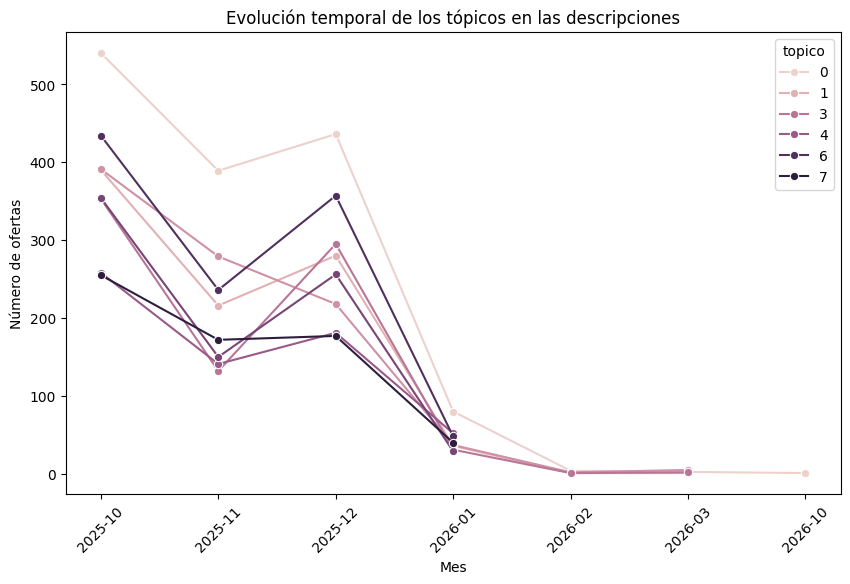

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


# Por mes
df['mes'] = df['timestamp'].dt.to_period('M')

# Conteo
temporal_topics = df.groupby(['mes', 'topico']).size().reset_index(name='cuenta')

# Convert 'mes' to string for plotting
temporal_topics['mes'] = temporal_topics['mes'].astype(str)

# Gráfico
plt.figure(figsize=(10,6))
sns.lineplot(data=temporal_topics, x='mes', y='cuenta', hue='topico', marker='o')
plt.title('Evolución temporal de los tópicos en las descripciones')
plt.xlabel('Mes')
plt.ylabel('Número de ofertas')
plt.xticks(rotation=45)
plt.show()

In [15]:
df_topics = pd.DataFrame(
    doc_topics,
    columns=[f"topico_{i}" for i in range(doc_topics.shape[1])],
    index=df.index  # para alinear con df original
)

# Concatenar con tu DataFrame original
df_final = pd.concat([pd.read_csv("dataPreparation/EURES_NUMERICO.csv"), df_topics], axis=1)

# Ahora puedes ver cada documento con todas las probabilidades
df_final.head()

,id,timestamp,provincia,titulo,sentimiento,Hostelería y Turismo,Sanitario y Salud,Educación y Formación,Tecnología y Telecomunicaciones,Construcción e Inmobiliaria,...,Administración y Finanzas,"Cultura, Arte y Ocio",topico_0,topico_1,topico_2,topico_3,topico_4,topico_5,topico_6,topico_7
0,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,Asturias,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),0,0.041410,0.120989,0.041578,0.059036,0.030720,...,0.324149,0.019736,0.814502,0.026324,0.027557,0.026324,0.026325,0.026324,0.026321,0.026323
1,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,Huesca,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,0,0.030985,0.057478,0.036354,0.029181,0.147310,...,0.018703,0.017910,0.009260,0.009275,0.009260,0.934946,0.009464,0.009271,0.009264,0.009260
2,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,Las Palmas,EDUCADORES SOCIALES,0,0.091417,0.192628,0.193099,0.050107,0.051788,...,0.115695,0.070076,0.055558,0.333313,0.333334,0.055559,0.055560,0.055560,0.055558,0.055559
3,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,Islas Baleares,PIZZERO (REF. 042025002051),0,0.321799,0.063992,0.053844,0.034645,0.072012,...,0.064227,0.136169,0.020914,0.021440,0.020892,0.020867,0.021608,0.123353,0.749986,0.020938
4,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,Santa Cruz de Tenerife,INTÉRPRETES DE LA LENGUA DE SIGNOS,0,0.080648,0.092984,0.213390,0.103763,0.021884,...,0.032571,0.312398,0.158010,0.683681,0.026455,0.026321,0.026574,0.026321,0.026319,0.026320


In [16]:
df_final.to_csv("empleos-espanoles-eures-2025-numerico.csv", index=False)